<a href="https://colab.research.google.com/github/grojasc/MIA/blob/main/DeepLearning_NB_GR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tarea 1 Deep Learning** ✊


*   Nestor Borre
*   Hermán Granszow
*   Gonzalo Rojas





# Importar Librerías

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation,Input,Conv2D,Activation,UpSampling2D,Conv2DTranspose,Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.constraints import maxnorm 
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torchvision
import torchvision.transforms as T

# Cargar Datasets

In [ ]:
from keras.datasets import cifar10
import tensorflow_datasets as tfds

In [ ]:
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # para incluir las etiquetas
)

print(f"Ejemplos entrenamiento: {tf.data.experimental.cardinality(train_ds)}")
print(f"Ejemplos validación: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Ejemplos test: {tf.data.experimental.cardinality(test_ds)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteIEZWVT/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Ejemplos entrenamiento: 9305
Ejemplos validación: 2326
Ejemplos test: 2326


# Pregunta A):
**Autoencoder**: construya y entrene un autoencoder convolucional para el set de datos CIFAR10. Haga un análisis de sensibilidad para el tamaño y forma (plana o rectangular) de la representación generada por el encoder (cuello de botella), graficando su tamaño/forma vs la pérdida de reconstrucción en los
sets de entrenamiento y validación. Visualice resultados que ejemplifiquen aciertos y errores en el set devalidación o test.


### Dividir datos

In [ ]:
(x_train, y_train) , (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


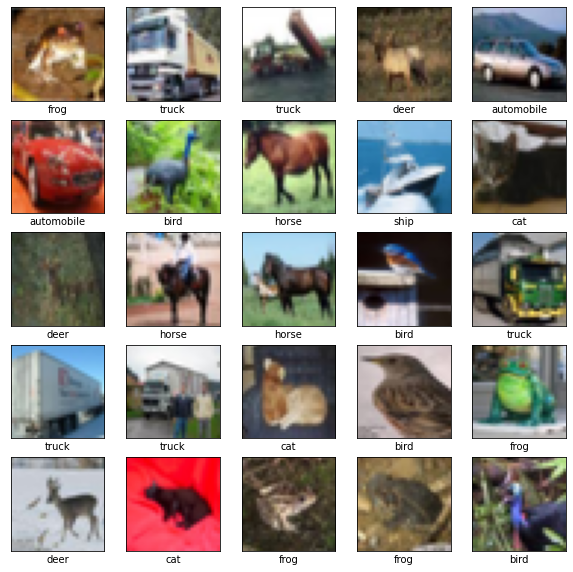

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/ 255.0
x_test = x_test / 255.0

In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (50000, 10, 2, 2, 2, 2)
y_test shape: (10000, 10, 2, 2, 2, 2)


### Modelamiento

In [ ]:
def create_convolution_ae(): #def create_convolution_ae
    input_img = Input((32,32,3))
    
    #encoder
    e = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    e = BatchNormalization()(e)
    e = MaxPooling2D((2, 2), padding='same') (e)
    e = Conv2D(8, (3, 3), activation='relu', padding='same')(e)
    e = BatchNormalization()(e)
    encoded = MaxPooling2D((2, 2), padding='same')(e)    

    #decoder
    d = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    d = BatchNormalization()(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(8, (3, 3), padding='same')(d)
    d = BatchNormalization()(d)
    #d = Activation('relu')(d)
    #d = Conv2D(32, (3, 3), activation='relu', padding='same')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(16, (3, 3), padding='same')(d)
    d = BatchNormalization()(d)
    #d = Activation('relu')(d)
    
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder = Model(input_img, encoded)
    return encoder, autoencoder

In [ ]:
encoder_conv, autoencoder_conv = create_convolution_ae()
autoencoder_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 8)        32    

In [ ]:
#Se entrenará el modelo
epochs = 3
batch_size = 512
history_auto=autoencoder_conv.fit(x_train, x_train,  epochs=epochs, batch_size=batch_size ,validation_data=(x_test, x_test))
#epochs = 2
#batch_size = 512
#print('forma de train_images: ', train_images.shape)
#print('forma de test_images: ', test_images.shape)
#print('forma de train_labels: ', train_labels.shape)
#print('forma de test_labels: ', test_labels.shape)

print(history_auto)

Epoch 1/3
98/98 [==============================] - 149s 2s/step - loss: 0.6245 - val_loss: 0.6516
Epoch 2/3
98/98 [==============================] - 157s 2s/step - loss: 0.5825 - val_loss: 0.6127
Epoch 3/3
98/98 [==============================] - 164s 2s/step - loss: 0.5763 - val_loss: 0.5897


In [ ]:
decoded_test = autoencoder_conv.predict(x_test)

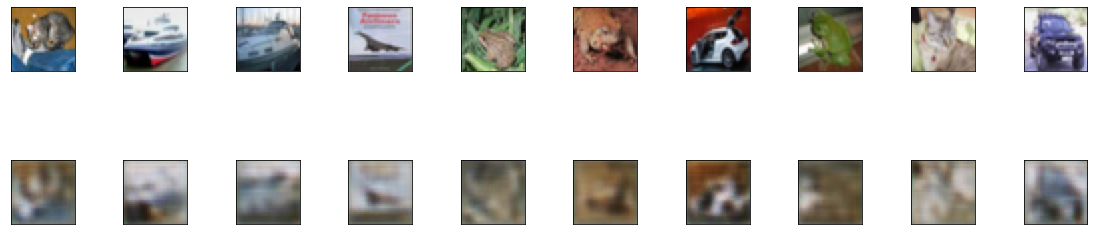

In [ ]:
plt.figure(figsize=(40,4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(decoded_test[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x


In [ ]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
              kernel_size=kernel_size,
              strides=2,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [ ]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [ ]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

### Entrenamiento

In [ ]:
batch_size = 32
num_classes = 10
epochs = 100
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
history = model.fit(x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test),
                    callbacks=es_cb
                    )

ValueError: ignored

# Nueva sección

In [ ]:
from keras.callbacks import TensorBoard

autoencoder_conv.fit(x_train, x_train,
                epochs=3,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/3
391/391 [==============================] - 152s 388ms/step - loss: 0.5629 - val_loss: 0.5631
Epoch 2/3
391/391 [==============================] - 151s 387ms/step - loss: 0.5618 - val_loss: 0.5624
Epoch 3/3
391/391 [==============================] - 152s 390ms/step - loss: 0.5611 - val_loss: 0.5614


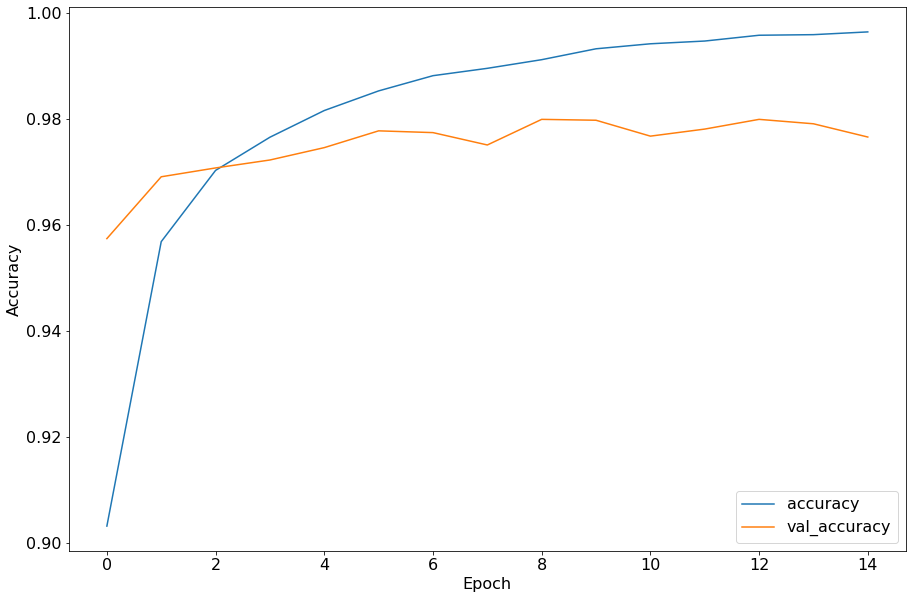

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

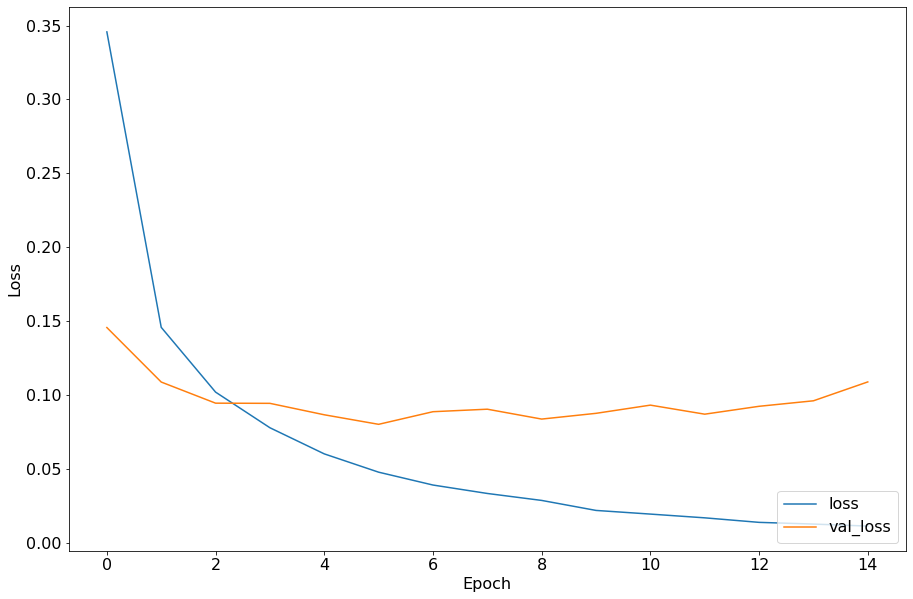

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 2s 0us/step


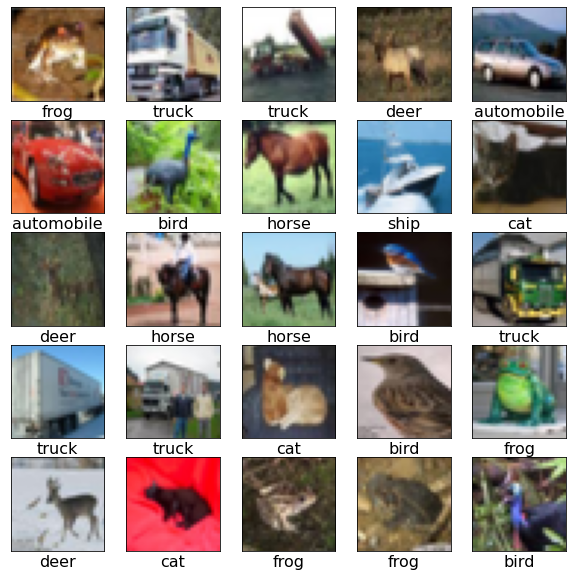

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
#MLP

MLP = models.Sequential()
MLP.add(layers.InputLayer(input_shape=(32,32,3)))
MLP.add(layers.Flatten())
MLP.add(layers.Dense(256, activation='relu', use_bias=True))
MLP.add(layers.Dense(256, activation='relu', use_bias=True))
MLP.add(layers.Dense(10))

MLP.summary()
MLP.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               786688    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
CNN = models.Sequential(
    [
        layers.InputLayer(input_shape=(32,32,3)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN.summary()
CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)             

In [ ]:
history_mlp = MLP.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8563 - accuracy: 0.3261 - val_loss: 1.7341 - val_accuracy: 0.3776
Epoch 2/30
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6816 - accuracy: 0.3968 - val_loss: 1.6564 - val_accuracy: 0.3999
Epoch 3/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6022 - accuracy: 0.4272 - val_loss: 1.5628 - val_accuracy: 0.4403
Epoch 4/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5523 - accuracy: 0.4440 - val_loss: 1.5340 - val_accuracy: 0.4484
Epoch 5/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5141 - accuracy: 0.4576 - val_loss: 1.5063 - val_accuracy: 0.4622
Epoch 6/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4842 - accuracy: 0.4709 - val_loss: 1.5137 - val_accuracy: 0.4588
Epoch 7/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4619 - accuracy: 0.4757 - val_loss: 1.4970 - val_accuracy:

In [ ]:
history_cnn = CNN.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1563/1563 [==============================] - 17s 5ms/step - loss: 1.5292 - accuracy: 0.4508 - val_loss: 1.2268 - val_accuracy: 0.5724
Epoch 2/30
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2130 - accuracy: 0.5733 - val_loss: 1.0770 - val_accuracy: 0.6156
Epoch 3/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0977 - accuracy: 0.6170 - val_loss: 0.9988 - val_accuracy: 0.6520
Epoch 4/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0332 - accuracy: 0.6399 - val_loss: 0.9415 - val_accuracy: 0.6765
Epoch 5/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9822 - accuracy: 0.6602 - val_loss: 0.9049 - val_accuracy: 0.6926
Epoch 6/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9456 - accuracy: 0.6706 - val_loss: 0.8672 - val_accuracy: 0.7068
Epoch 7/30
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9093 - accuracy: 0.6837 - val_loss: 0.8632 - val_accuracy